In [1]:
# third party libraries
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import copy
import pickle
from statsmodels.tsa.arima_model import ARIMA
from sklearn import linear_model
from itertools import combinations, product

# personal libraries
from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
import scipy.optimize

def reg_syn_control(X,y):
    """
    Convex regression.
    
    The optimization objective for synthetic control is:
    
        ||y - Xw||^2_2
        Constrained: w>=0 & \sum_i(w_i)=1
    
    Parameters
    ----------
    X: shape (p,n)
    y: shape (p)
    
    """
    p,n = X.shape

    #Objective function
    def f(w):
        return ((np.dot(X,w) - y)**2).sum()
    
    def jac_f(w):
        return (-(2*((y-np.dot(X,w)).T).dot(X)))
    
    #Defining constraints
    def sum_con(w):
        return (np.ones((n)).dot(w) - 1)
    dic_sum_con = {"type":"eq","fun":sum_con}
    
    def positive_con(w):
        return w
    dic_positive_con = {"type":"ineq","fun":positive_con}
    
    cons = [dic_sum_con,dic_positive_con]
    
    #Scipy optimization
    result = scipy.optimize.minimize(f, np.ones(n)/n, jac = jac_f,constraints = cons,method="SLSQP")
    return result

# Data Prep Methods

In [3]:
def prepareData(stats):
    # transform stats to a dictionary composed of df's for each stat
    # the stats are re-calculated to get one stat for each year
    metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P","MP"]
    metricsPerGameDict = getMetricsPerGameDict(stats, metricsPerGameColNames)

    metricsPerCentColNames = ["FG","FT"]
    metricsPerCentDict = getMetricsPerCentDict(stats, metricsPerCentColNames)

    metricsWeightedColNames = ["PER"]
    metricsWeightedDict = getMetricsWeightedDict(stats, metricsWeightedColNames)

    allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
    allPivotedTableDict = getPivotedTableDict(allMetricsDict)
    allMetrics = list(allMetricsDict.keys())
    return allPivotedTableDict, allMetrics

def getTopPlayers(stats, year, metric, n):
    stats = stats[stats.Year == year]
    stats = stats.groupby('Player').mean().reset_index()
    stats_sorted = stats[stats.Year == year].sort_values(metric, ascending = False).reset_index(drop=True)
    return stats_sorted[["Player"]][:n]

# bug in playerName
def getBenchmark(target, metrics_to_use, pred_interval):    
    target_data, nanIndex = target.concat(metrics_to_use)
    num_k = len(metrics_to_use)
    interv_index = int(target_data.shape[1]/num_k - pred_interval)
    total_index = int(interv_index + 1)
    
    # true
    true = utils.get_postint_data(target_data, interv_index, total_index, num_k).T
    true.index = metrics_to_use
    
    # predictions
    history = utils.get_preint_data(target_data, interv_index, total_index, num_k)
    pred = []
    for i in range(num_k):
        pred.append(history.iloc[:,i*interv_index:(i+1)*interv_index].mean(axis=1).to_list())

    #pred = pd.DataFrame(pred, index=metrics_to_use, columns = [playerName]) #bug
    pred = pd.DataFrame(pred, index=metrics_to_use, columns = [target.key])
    return true, pred

def getR2(true, pred, bench):
    ss_res = pd.DataFrame((true.values - pred.values)**2, index=true.index).sum(axis=1)
    ss_tot = pd.DataFrame((true.values - bench.values)**2, index=true.index).sum(axis=1)
    return (1-ss_res/ss_tot).to_frame(name = pred.columns.values[0])

In [4]:
def create_target_donors(params):
    starting_year = params[0]
    min_games = params[1]
    min_years = params[2]
    pred_year = params[3]
    pred_interval = params[4]
    
    """ players dataframe """
    players = pd.read_csv("../data/nba-players-stats/player_data.csv")

    # sort players by (name, year_start)
    players = players.sort_values(by=['name', 'year_start'])

    # filter players by years considered
    players = players[players.year_start >= starting_year] 


    """ stats dataframe """
    stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")

    # fix the name* issue
    stats = stats.replace('\*','',regex=True)

    # sort players by (name, year)
    stats = stats.sort_values(by=['Player', 'Year'])

    # remove multiple rows for the same [Year, Player]
    totals = stats[stats.Tm == "TOT"]
    duplicates_removed = stats.drop_duplicates(subset=["Year", "Player"], keep=False)
    stats = pd.concat([duplicates_removed, totals], axis=0).sort_values("Unnamed: 0")

    # filter players by years considered
    stats = stats[stats.Year >= starting_year]

    """ players + stats dataframes """
    valid_players = list(set(stats.Player) & set(players.name))
    stats = stats[stats['Player'].isin(valid_players)]
    players = players[players['name'].isin(valid_players)]

    # correct names in "players" dataframe
    duplicate_names = []
    for name in players.name:
        numrows = len(players[players['name']==name])
        if numrows == 2:
            duplicate_names.append(name)
            i = 0
            for birth_date in players.loc[players['name']==name, 'birth_date']:
                if i == 1:
                    players.loc[(players['name']==name) & (players['birth_date']==birth_date) , 'name'] = name + ' Jr'
                i += 1
        elif numrows == 3:
            players = players[players.name != name]

    # correct names in "stats" dataframe
    stats = fix_duplicates(stats, duplicate_names)

    # merge
    players = players.rename(columns={"name": "Player"})
    stats = pd.merge(stats, players, on='Player', how='left')
    # sanity check 
    stats = stats[(stats.Year >= stats.year_start) & (stats.Year <= stats.year_end)]

    stats.Year = stats.Year.astype(int)
    stats.year_start = stats.year_start.astype(int)
    stats['year_count'] = stats.Year - stats.year_start

    """ donor setup """
    # only consider years prior to 'pred_year'
    stats_donor = stats[stats.Year < pred_year]
    stats_donor = stats_donor.sort_values(by=['Player', 'Year'])

    # only consider years in which at least "min_games" number of games were played
    stats_donor = stats_donor[stats_donor.G >= min_games]

    # edit 'year_count'
    stats_donor = edit_year_count(stats_donor)

    # create donor object
    allPivotedTableDict_d, allMetrics = prepareData(stats_donor)
    donor = Donor(allPivotedTableDict_d)

    """ target setup """
    # consider all years up to (and including) 'pred_year'
    stats_target = stats[stats.Year <= pred_year]

    # exclude years prior to 'pred_year' in which < 'min_games' were played
    idx = stats_target.loc[(stats_target.G < min_games) & (stats_target.Year < pred_year)].index
    stats_target.drop(idx, inplace=True)

    # edit 'year_count'
    stats_target = edit_year_count(stats_target)

    # create target dictionary of values
    allPivotedTableDict, allMetrics = prepareData(stats_target)

    # get target player names
    targetNames = get_active_players(stats_target, pred_year, min_years, min_games) 
    targetNames.sort()

    if 'Kevin Garnett' in targetNames: 
        targetNames.remove("Kevin Garnett")
    if 'Kobe Bryant' in targetNames:
        targetNames.remove("Kobe Bryant")

    print("*** DONE! ***")

    return donor, allPivotedTableDict, targetNames, stats
    

# Data Prep Fix Methods

In [5]:
def edit_year_count(df):
    for player in df.Player.unique():
        df.loc[df.Player == player, 'year_count'] = np.arange(len(df[df.Player == player]))
    return df

"""
only fixes for names that appear TWICE
"""
def fix_duplicates(stats, duplicate_names):
    for player in duplicate_names:
        y_true = stats[stats.Player==player]['Year'].values
        y_old = np.arange(np.min(y_true), np.min(y_true) + len(y_true))
        idx = np.nonzero(y_true - y_old)[0]
        years = y_true[idx]
        stats.loc[(stats['Player'] == player) & (stats['Year'].isin(years)), 'Player'] = player + ' Jr'
    return stats

""" 
retrive players who played in 'pred_year' who satisfy the following:
1. played at least 'min_games' in 'pred_year' 
2. played at least 'buffer' seasons, where each admissible season has > 'min_games'
"""
def get_active_players(stats_target, pred_year, buffer, min_games):
    df = stats_target.copy()    
    
    # minimum number of years a player must have played in NBA
    year_min = pred_year - buffer

    # only consider players that played at least 'min_games' in 'pred_year' 
    active = df.loc[(df.Year == pred_year) & (df.G >= min_games), 'Player'].tolist()

    # consider remaining players who played >= 'buffer' seasons (prior to 'pred_year') with > 'min_games'
    df = df.loc[df.Player.isin(active)]
    counts = df['Player'].value_counts()
    df = df[df['Player'].isin(counts[counts > buffer].index)].sort_values(by=['Player'])
    active = df['Player'].unique()
    
    return active.tolist()

# Plotting Methods

In [6]:
def plot_pred(pred_traj, true_traj, markers_on, metric, playerName, dir_name):
    dir_name_metric = dir_name + metric + '/'
    plt.figure()
    plt.plot(pred_traj, marker='o', markevery=markers_on, color='blue', label='Prediction')
    plt.plot(true_traj, marker='o', color='red', label='True')
    plt.xticks(range(len(true_traj)), range(1, len(true_traj)+1))
    #plt.legend(loc='best')
    plt.legend(loc='upper left')
    plt.xlabel('Years in NBA')
    plt.ylabel(metric)
    plt.title(playerName + ': ' + metric)
    file_name = dir_name_metric + playerName + '.png'
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()   

# Prediction Methods

In [308]:
""" 
Predict via MRSC
intuition: use other players (historical and current) to create a synthetic version of 'targetPlayer' to forecast
"""
def mrsc_predict(targetPlayer, allPivotedTableDict, donor, pred_interval, metric, pred_metrics,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose):
    
    # create target object
    target = Target(targetPlayer, allPivotedTableDict)
    
    # create mrsc model 
    mrsc = mRSC(donor, target, pred_interval, probObservation=1)
    
    # fit model
    mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup, regression_method, verbose)
    
    # predict model for 'pred_metric'
    pred = mrsc.predict()
    pred = pred[pred.index.isin(pred_metrics)]
    
    return pred

"""
Predict via ARIMA
intuition: use 'targetPlayer' data to capture momentum
"""
def arima_predict(train, test, params=(1,1,0)): 
    predictions = list()
    history = [y for y in train]
    for t in range(len(test)): 
        model = ARIMA(history, order=params)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return predictions

"""
Get predictions from all models and true value
"""
def get_predictions(targetPlayer, allPivotedTableDict, donor, pred_interval, metric, pred_metrics,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose, arima_params, ewm_param):
    # get MRSC prediction
    pred1 = mrsc_predict(targetPlayer, allPivotedTableDict, donor, pred_interval, metric, pred_metrics,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose)
    pred1 = pred1.values.flatten()[0]
        
    # get ARIMA prediction
    df = allPivotedTableDict[metric[0]]
    df = df[df.index == targetPlayer]
    df.dropna(axis='columns', inplace=True)
    num_years = df.shape[1] - 1
    train_years = np.arange(num_years)
    test = df.loc[:, num_years].values.flatten()
    
    # w/o ewm
    train = df.loc[:, train_years].values.flatten()
    pred2 = arima_predict(train, test, arima_params)
    pred2 = pred2[0][0]
    
    # w/ ewm
    train_ewm = df.loc[:, train_years].T.ewm(com=ewm_param).mean().values.flatten()
    pred3 = arima_predict(train_ewm, test, arima_params)
    pred3 = pred3[0][0]
    
    # concatenate predictions
    pred = np.array([pred1, pred2, pred3]).reshape((1,3))
    
    return pred, test


"""
Learn Weights for Predictions
"""
def learn_prediction_weights(x, y, method='Ridge', alpha=0.1):
    if method == 'Convex':
        regr = reg_syn_control(x, y)
        weights = regr.x
    elif method == 'Linear':
        regr = linear_model.LinearRegression(fit_intercept=False)
        regr.fit(x, y)
        weights = regr.coef_
    else:
        regr = linear_model.Ridge(fit_intercept=False, alpha=alpha)
        regr.fit(x, y)
        weights = regr.coef_
    return weights

"""
Combine Predictions into Single Prediction
"""
def combine_predictions(predictions, weights): 
    return np.dot(predictions, weights)

# *** DATA PREPARATION ***

In [9]:
""" USER PARAMETERS """
starting_year = 1970
min_games = 30
min_years = 4
validate_year = 2016
pred_interval = 1
params = [starting_year, min_games, min_years, validate_year, pred_interval]

# *** EXPERIMENTAL SECTION ***

In [10]:
predMetrics = ["PTS_G","AST_G","TOV_G","3P_G","TRB_G","STL_G","BLK_G"]
offMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G"]
defMetrics = ["TRB_G","STL_G","BLK_G"]

In [11]:
"""
setup
"""
# user input
donor_window_type = 'sliding'
normalize_metric = None 
threshold = 0.98
helper_metrics = []

# setup 
donorSetup= [normalize_metric, donor_window_type, True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
verbose = False
metrics = [[metric] + helper_metrics for metric in predMetrics]

In [12]:
# create donor / target for validation
donor_v, allPivotedTableDict_v, _, _ = create_target_donors(params)

# create donor / target for testing (update prediction year)
params[3] = params[3] + 1
donor, allPivotedTableDict, targetPlayers, stats = create_target_donors(params)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


*** DONE! ***
*** DONE! ***


In [65]:
topPlayers = getTopPlayers(stats, params[3], 'PTS', 30)
topPlayers = topPlayers.values.flatten()
Players = list(set(targetPlayers) & set(topPlayers))

In [329]:
Players = ['Russell Westbrook', 'James Harden',
       'DeMar DeRozan', 'Stephen Curry', 'LeBron James',
       'Kawhi Leonard',
        'Kemba Walker',
       'Kyrie Irving', 'Jimmy Butler', 'John Wall', 'Dwyane Wade',
       'Paul George', 'Klay Thompson', 'Carmelo Anthony',
       'Gordon Hayward', 'Kevin Durant', 'Brook Lopez',
       'Goran Dragic', 'Marc Gasol', 'Lou Williams', 'Chris Paul',
          'Al Horford', 'Al Jefferson','LaMarcus Aldridge', 'Manu Ginobili', 'Tony Parker',
          'Dwight Howard', 'Trevor Ariza', 'Zach Randolph', 'Vince Carter', 'Rudy Gay', 'Kevin Love',
          'Dirk Nowitzki', 'DeAndre Jordan', 'Blake Griffin', 'Andre Iguodala', 'Arron Afflalo',
          'Avery Bradley', 'Beno Udrih', 'C.J. Miles', 'Corey Brewer', 'David Lee', 'David West',
          'Deron Williams', 'Derrick Rose', 'Greg Monroe', 'J.J. Barea',
 'J.J. Redick', 'J.R. Smith', 'Jamal Crawford', 'Jameer Nelson', 'Jason Terry', 'Jeff Green', 'Jared Dudley', 'Joe Johnson', 
          'Jose Calderon', 'Kenneth Faried', 'Kyle Korver', 'Kyle Lowry', 'Leandro Barbosa', 'Marcin Gortat',
 'Marco Belinelli', 
 'Marcus Thornton',
 'Marreese Speights',
 'Marvin Williams',
 'Matt Barnes', 'Mike Conley', 'Michael Beasley','Monta Ellis',
 'Nene Hilario',
 'Nick Young',
 'Nicolas Batum','Omer Asik',
 'Omri Casspi',
           'Pau Gasol',
           'Paul Millsap',
 'Rajon Rondo',
 'Ramon Sessions',
 'Randy Foye',
 'Raymond Felton',
 'Reggie Jackson',
 'Richard Jefferson',
 'Robin Lopez',
 'Rodney Stuckey',
 'Roy Hibbert',
          'Serge Ibaka',
 'Shaun Livingston',
 'Spencer Hawes','Taj Gibson', 'Tony Allen', 'Wayne Ellington',
 'Wesley Johnson',
 'Wesley Matthews', 'Zaza Pachulia']

In [199]:
Players = ['Russell Westbrook', 'James Harden',
       'DeMar DeRozan', 'Stephen Curry', 'LeBron James',
       'Kawhi Leonard',
        'Kemba Walker',
       'Kyrie Irving', 'Jimmy Butler', 'John Wall', 'Dwyane Wade',
       'Paul George', 'Klay Thompson', 'Carmelo Anthony',
       'Gordon Hayward', 'Kevin Durant', 'Brook Lopez',
       'Goran Dragic', 'Marc Gasol', 'Chris Paul',
          'LaMarcus Aldridge', 'Rudy Gay', 'Blake Griffin']
Players.sort()

In [333]:
Players = ['Russell Westbrook', 'James Harden',
       'DeMar DeRozan', 'Stephen Curry', 'LeBron James',
       'Kawhi Leonard',
        'Kemba Walker',
       'Kyrie Irving', 'Jimmy Butler', 'John Wall', 'Dwyane Wade',
       'Paul George', 'Klay Thompson', 'Carmelo Anthony',
       'Gordon Hayward', 'Kevin Durant', 'Brook Lopez',
       'Goran Dragic', 'Marc Gasol', 'Lou Williams', 'Chris Paul',
          'Al Horford', 'Al Jefferson','LaMarcus Aldridge', 'Manu Ginobili', 'Tony Parker',
          'Dwight Howard', 'Trevor Ariza', 'Zach Randolph', 'Vince Carter', 'Rudy Gay', 'Kevin Love',
          'Dirk Nowitzki', 'DeAndre Jordan', 'Blake Griffin']

In [334]:
# create evaluation dataframes
all_pred = pd.DataFrame()
all_true = pd.DataFrame()
all_val = pd.DataFrame()
all_bench = pd.DataFrame()
all_R2 = pd.DataFrame()

method = 'Convex'
alpha = 0.1
arima_params = (1,1,0)
ewm_param = 0.5

# use 'targetPlayers' from 'pred_year'
for targetPlayer in Players:  
    #print(targetPlayer)
    
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    player_val = pd.DataFrame()
    
    for metric in [['PTS_G']]: 
    #for metric in metrics:
        #print(metric)
        
        """ VALIDATION STAGE """
        # get predictions
        preds_val, y_val = get_predictions(targetPlayer, allPivotedTableDict_v, donor_v, pred_interval, metric, predMetrics,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose, arima_params, ewm_param)
        
        # learn weights
        weights = learn_prediction_weights(preds_val, y_val, method, alpha)
        
        """ PREDICTION STAGE """
        # get predictions
        preds_test, y_test = get_predictions(targetPlayer, allPivotedTableDict, donor, pred_interval, metric, predMetrics,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose, arima_params, ewm_param)
        
        # make final predictions
        pred_final = combine_predictions(preds_test, weights) 
        
        """ PRESENTATION STAGE """
        df_val = pd.DataFrame(y_val)
        df_val.columns = [targetPlayer]
        df_val.index = [metric]
        player_val = pd.concat([player_val, df_val], axis=0)
        
        df_pred = pd.DataFrame(pred_final)
        df_pred.columns = [targetPlayer]
        df_pred.index = [metric]
        player_pred = pd.concat([player_pred, df_pred], axis=0)
        
        df_true = pd.DataFrame(y_test)
        df_true.columns = [targetPlayer]
        df_true.index = [metric]
        player_true = pd.concat([player_true, df_true], axis=0)
        
    all_pred = pd.concat([all_pred, player_pred], axis=1)
    all_true = pd.concat([all_true, player_true], axis=1)
    all_val = pd.concat([all_val, player_val], axis=1)
    #all_bench = pd.concat([all_bench, benchmark], axis=1)

print("*** {} ***".format(method))
print()
    
print("Number of metrics: {}".format(all_pred.shape[0]))
print("Number of players: {}".format(all_pred.shape[1]))
print()
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


*** Convex ***

Number of metrics: 1
Number of players: 35

*** MAPE ***
PTS_G    0.129237
dtype: float64
MAPE for all:  0.1292371230934144

*** RMSE ***
PTS_G    2.984171
dtype: float64
RMSE for all:  2.9841714951610125


In [ ]:
*** Convex ***

Number of metrics: 1
Number of players: 35

*** MAPE ***
PTS_G    0.129
dtype: float64
MAPE for all:  0.129

*** RMSE ***
PTS_G    2.984
dtype: float64
RMSE for all:  2.984

In [ ]:
*** Convex ***

Number of metrics: 1
Number of players: 94

*** MAPE ***
PTS_G    0.232
dtype: float64
MAPE for all:  0.232

*** RMSE ***
PTS_G    2.786022
dtype: float64
RMSE for all:  2.786

In [295]:
#diff = all_true - all_pred
all_val.index = ['Prev']
all_true.index = ['True']
all_pred.index = ['Mixed']
diff.index = ['Error Mixed']
df_diff = pd.concat([all_val, all_true, all_pred, diff]).T
df_diff = df_diff.sort_values(by=['Error Mixed'])
df_diff['MRSC'] = np.array([25.58090591, 15.78226711, 26.34702563, 18.13666497, 21.98163483,
       24.13718154, 27.37958144, 14.49752565, 22.9211566 , 16.18363636,
       18.92039987, 19.18149512, 20.97808008, 19.67936852, 19.75344847,
       20.26014034, 18.16036815, 16.13480465, 17.2252078 , 20.9538986 ,
       15.41459691, 18.76911398, 22.63992551])
df_diff['Error MRSC'] = np.array([-0.27710844,  2.31609355, -1.26638047, -0.87277608,  0.3516985 ,
       -0.47051487,  1.70683831,  3.76914102,  0.97358025,  3.35690418,
        2.65337062,  3.98306184,  5.42732533,  5.83414499,  2.17805837,
        2.15877858,  2.35963185,  2.59852868,  5.91581784,  6.3433987 ,
        4.90047158,  6.45310825,  8.9403214 ])
df_diff = df_diff[['Prev', 'True', 'Mixed', 'MRSC', 'Error Mixed', 'Error MRSC']]
df_diff.round(3)

,Prev,True,Mixed,MRSC,Error Mixed,Error MRSC
Stephen Curry,30.063,25.304,28.642,25.581,-4.440,-0.277
Chris Paul,19.541,18.098,19.736,15.782,-1.743,2.316
Kevin Durant,28.181,25.081,26.765,26.347,-1.648,-1.266
LaMarcus Aldridge,17.986,17.264,18.137,18.137,-0.873,-0.873
Klay Thompson,22.138,22.333,23.276,21.982,-0.609,0.352
Paul George,23.136,23.667,24.460,24.137,-0.608,-0.471
James Harden,28.976,29.086,29.580,27.380,-0.400,1.707
Dwyane Wade,19.041,18.267,17.247,14.498,0.886,3.769
Jimmy Butler,20.881,23.895,22.921,22.921,0.974,0.974
Marc Gasol,16.558,19.541,16.184,16.184,1.183,3.357


In [ ]:
*** Convex ***

Number of metrics: 1
Number of players: 94

*** MAPE ***
PTS_G    0.234
dtype: float64
MAPE for all:  0.234

*** RMSE ***
PTS_G    2.843
dtype: float64
RMSE for all:  2.843

In [ ]:
*** MRSC ONLY ***

Number of metrics: 1
Number of players: 94

*** MAPE ***
PTS_G    0.240
dtype: float64
MAPE for all:  0.240

*** RMSE ***
PTS_G    3.125
dtype: float64
RMSE for all:  3.125

In [ ]:
*** MRSC ONLY ***

Number of metrics: 1
Number of players: 35

*** MAPE ***
PTS_G    0.160
dtype: float64
MAPE for all:  0.160

*** RMSE ***
PTS_G    3.792
dtype: float64
RMSE for all:  3.792

In [ ]:
*** Convex ***

Number of metrics: 1
Number of players: 35

*** MAPE ***
PTS_G    0.128
dtype: float64
MAPE for all:  0.128

*** RMSE ***
PTS_G    3.012
dtype: float64
RMSE for all:  3.012

In [ ]:
*** Ridge ***

Number of metrics: 1
Number of players: 35

*** MAPE ***
PTS_G    0.120355
dtype: float64
MAPE for all:  0.1203548031748765

*** RMSE ***
PTS_G    3.570954
dtype: float64
RMSE for all:  3.570954225556086

In [ ]:
*** Linear ***

Number of metrics: 1
Number of players: 20

*** MAPE ***
PTS_G    0.125821
dtype: float64
MAPE for all:  0.12582098918573906

*** RMSE ***
PTS_G    4.228453
dtype: float64
RMSE for all:  4.228453347261419

In [ ]:
*** Convex ***

Number of metrics: 1
Number of players: 20

*** MAPE ***
PTS_G    0.107637
dtype: float64
MAPE for all:  0.10763726812530057

*** RMSE ***
PTS_G    3.38983
dtype: float64
RMSE for all:  3.3898300688908627

In [ ]:
*** Ridge ***

Number of metrics: 1
Number of players: 20

*** MAPE ***
PTS_G    0.125861
dtype: float64
MAPE for all:  0.1258614346451613

*** RMSE ***
PTS_G    4.228887
dtype: float64
RMSE for all:  4.228887246453262

In [ ]:
*** MRSC ONLY ***

Number of metrics: 1
Number of players: 20

*** MAPE ***
PTS_G    0.155818
dtype: float64
MAPE for all:  0.15581755118078194

*** RMSE ***
PTS_G    4.391406
dtype: float64
RMSE for all:  4.391406286806528

In [ ]:
def annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics, pred_metrics,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name, top_players):
    all_pred = pd.DataFrame()
    all_true = pd.DataFrame()
    all_bench = pd.DataFrame()
    all_R2 = pd.DataFrame()
    
    for playerName in playerNames:
        if playerName in top_players:
            dir_name_player = dir_name + 'top_players/'
        else:
            dir_name_player = dir_name + 'rest/'
            
        target = Target(playerName, allPivotedTableDict)
        mrsc = mRSC(donor, target, pred_interval, probObservation=1)        
        player_pred = pd.DataFrame()
        player_true = pd.DataFrame()
        
        # benchmark
        true, benchmark = getBenchmark(target, pred_metrics, pred_interval)
        
        for metric in metrics:
            mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)
            pred = mrsc.predict()
            pred = pred[pred.index.isin(pred_metrics)]
            true = mrsc.getTrue()
            pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
            true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
            player_pred = pd.concat([player_pred, pred], axis=0)
            player_true = pd.concat([player_true, true], axis=0)

            # plot
            for i in range(mrsc.num_k):
                metric_plt = mrsc.metrics[i]
                true_traj = mrsc.target.data[metric_plt].dropna(axis='columns').values.flatten()
                pred_traj = np.dot(mrsc.model.donor_pre.iloc[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].T, 
                                   mrsc.model.beta).flatten()

                if mrsc.weighting != None:
                    mean_pre = utils.get_preint_data(combinedDF=mrsc.weights[0].to_frame().T,
                                                    intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                                    nbrMetrics=mrsc.num_k, reindex=True).values
                    var_pre = utils.get_preint_data(combinedDF=mrsc.weights[1].to_frame().T,
                                                    intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                                    nbrMetrics=mrsc.num_k, reindex=True).values
                    mean_pre = mean_pre[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].flatten()
                    var_pre = var_pre[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].flatten()
                    pred_traj = (pred_traj * np.sqrt(var_pre.T)) + mean_pre.T

                markers_on = np.arange(pred_traj.shape[0], true_traj.shape[0]).tolist()
                pred_traj = np.append(pred_traj, pred[pred.index==metric_plt].values.flatten())
                #markers_on = [true_traj.shape[0]-mrsc.pred_interval]
                plot_pred(pred_traj, true_traj, markers_on, metric_plt, playerName, dir_name_player)
    
        all_pred = pd.concat([all_pred, player_pred], axis=1)
        all_true = pd.concat([all_true, player_true], axis=1)
        all_bench = pd.concat([all_bench, benchmark], axis=1)

        #R2 = getR2(player_true, player_pred, benchmark)
        #all_R2 = pd.concat([all_R2, R2], axis=1)

    ###################
    print("Number of metrics: {}".format(all_pred.shape[0]))
    print("Number of players: {}".format(all_pred.shape[1]))
    print()
    mask = (all_true !=0 )
    mape = np.abs(all_pred[mask] - all_true[mask]) / all_true[mask]
    print("*** MAPE ***")
    print(mape.mean(axis=1))
    print("MAPE for all: ", mape.mean().mean())
    
    rmse = utils.rmse_2d(all_true, all_pred)
    print()
    print("*** RMSE ***")
    print(rmse)
    print("RMSE for all: ", rmse.mean())
    
    return all_pred, all_true
    ##############################################################

In [ ]:
""" 
directory path
"""
# donor window type
donor_window_label = donor_window_type + '/'

# prediction method
helper_metrics_label = ''
if helper_metrics:
    pred_method = 'mrsc/'
    for helper_metric in helper_metrics: 
        helper_metrics_label = helper_metrics_label + helper_metric + '_'
    helper_metrics_label += '/'
else:
    pred_method = 'rsc/'
    
# prediction year
pred_year_label = str(pred_year) + '/'

# metric normalizing type
if normalize_metric == None:
    normalize_metric_label = 'no_normalization/'
else:
    normalize_metric_label = normalize_metric + '/'
    
# singular value threshold energy level 
threshold_label = str(threshold*100)[:2] + '/'

# prediction length
pred_length_label = str(pred_interval) + 'year/'
    
dir_name = 'plots/' + pred_method + pred_year_label + donor_window_label + normalize_metric_label + helper_metrics_label + pred_length_label
    
print(dir_name)

In [48]:
# create donor / target for validation
donor_v, allPivotedTableDict_v, _, _ = create_target_donors(params)

# create donor / target for testing (update prediction year)
params[3] = params[3] + 1
donor, allPivotedTableDict, targetPlayers, stats = create_target_donors(params)

*** DONE! ***
*** DONE! ***


In [66]:
targetPlayer = 'James Harden'
metric = metrics[0]
print(metric)

['PTS_G']


In [67]:
target = Target(targetPlayer, allPivotedTableDict_v)
mrsc = mRSC(donor_v, target, pred_interval, probObservation=1)  
#mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup, regression_method, verbose)
#pred = mrsc.predict()

In [ ]:
target = Target(playerName, allPivotedTableDict)
        mrsc = mRSC(donor, target, pred_interval, probObservation=1)        
        player_pred = pd.DataFrame()
        player_true = pd.DataFrame()
        
        # benchmark
        true, benchmark = getBenchmark(target, pred_metrics, pred_interval)
        
        for metric in metrics:
            mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)
            pred = mrsc.predict()

In [61]:
pred1 = mrsc_predict(targetPlayer, allPivotedTableDict_v, donor_v, pred_interval, metric, predMetrics,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose)
pred1 = pred1.values.flatten()[0]

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Float64Index'> with these indexers [7.0] of <class 'numpy.float64'>

In [ ]:
def learn_prediction_weights(x, y, alpha=0.1): 
    regr = linear_model.Ridge(fit_intercept=False, alpha=alpha)
    regr.fit(x, y)
    return regr.coef_

"""
Combine Predictions into Single Prediction
"""
def combine_predictions(predictions, weights): 
    return np.dot(predictions, weights)

In [ ]:
def annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics, pred_metrics,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name, top_players):
    all_pred = pd.DataFrame()
    all_true = pd.DataFrame()
    all_bench = pd.DataFrame()
    all_R2 = pd.DataFrame()
    
    for playerName in playerNames:
        if playerName in top_players:
            dir_name_player = dir_name + 'top_players/'
        else:
            dir_name_player = dir_name + 'rest/'
            
        target = Target(playerName, allPivotedTableDict)
        mrsc = mRSC(donor, target, pred_interval, probObservation=1)        
        player_pred = pd.DataFrame()
        player_true = pd.DataFrame()
        
        # benchmark
        true, benchmark = getBenchmark(target, pred_metrics, pred_interval)
        
        for metric in metrics:
            mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)
            pred = mrsc.predict()
            pred = pred[pred.index.isin(pred_metrics)]
            true = mrsc.getTrue()
            pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
            true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
            player_pred = pd.concat([player_pred, pred], axis=0)
            player_true = pd.concat([player_true, true], axis=0)

            # plot
            for i in range(mrsc.num_k):
                metric_plt = mrsc.metrics[i]
                true_traj = mrsc.target.data[metric_plt].dropna(axis='columns').values.flatten()
                pred_traj = np.dot(mrsc.model.donor_pre.iloc[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].T, 
                                   mrsc.model.beta).flatten()

                if mrsc.weighting != None:
                    mean_pre = utils.get_preint_data(combinedDF=mrsc.weights[0].to_frame().T,
                                                    intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                                    nbrMetrics=mrsc.num_k, reindex=True).values
                    var_pre = utils.get_preint_data(combinedDF=mrsc.weights[1].to_frame().T,
                                                    intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                                    nbrMetrics=mrsc.num_k, reindex=True).values
                    mean_pre = mean_pre[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].flatten()
                    var_pre = var_pre[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].flatten()
                    pred_traj = (pred_traj * np.sqrt(var_pre.T)) + mean_pre.T

                markers_on = np.arange(pred_traj.shape[0], true_traj.shape[0]).tolist()
                pred_traj = np.append(pred_traj, pred[pred.index==metric_plt].values.flatten())
                #markers_on = [true_traj.shape[0]-mrsc.pred_interval]
                plot_pred(pred_traj, true_traj, markers_on, metric_plt, playerName, dir_name_player)
    
        all_pred = pd.concat([all_pred, player_pred], axis=1)
        all_true = pd.concat([all_true, player_true], axis=1)
        all_bench = pd.concat([all_bench, benchmark], axis=1)

        #R2 = getR2(player_true, player_pred, benchmark)
        #all_R2 = pd.concat([all_R2, R2], axis=1)

    ###################
    print("Number of metrics: {}".format(all_pred.shape[0]))
    print("Number of players: {}".format(all_pred.shape[1]))
    print()
    mask = (all_true !=0 )
    mape = np.abs(all_pred[mask] - all_true[mask]) / all_true[mask]
    print("*** MAPE ***")
    print(mape.mean(axis=1))
    print("MAPE for all: ", mape.mean().mean())
    
    
    return all_pred, all_true
    ##############################################################

In [205]:
playerName = 'James Harden'
metric = ['PTS_G']

target = Target(playerName, allPivotedTableDict)
mrsc = mRSC(donor, target, pred_interval, probObservation=1)        
mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)

df_pts = allPivotedTableDict['PTS_G']
train = df_pts.loc[df_pts.index==playerName, [0,1,2,3,4,6]].values.flatten()
test = df_pts.loc[df_pts.index==playerName, 7].values.flatten()

pred1 = mrsc.predict().values.flatten()[0]
pred1

pred2 = arima_forecast(train, test, params=(1,1,0))[0][0]
pred2 

In [206]:
pred1 = mrsc.predict().values.flatten()[0]
pred1

27.379581440931815

In [207]:
df_pts = allPivotedTableDict['PTS_G']
train = df_pts.loc[df_pts.index==playerName, [0,1,2,3,4,6]].values.flatten()
test = df_pts.loc[df_pts.index==playerName, 7].values.flatten()

In [208]:
test

array([29.08641975])

In [209]:
from statsmodels.tsa.arima_model import ARIMA

def arima_forecast(train, test, params=(5,1,0)): 
    predictions = list()
    history = [y for y in train]
    for t in range(len(test)): 
        model = ARIMA(history, order=params)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    plt.figure()
    plt.plot(test, color='blue', label='observations')
    plt.plot(predictions, color='green', label='predictions')
    plt.legend(loc='best')
    plt.show()
    return predictions

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

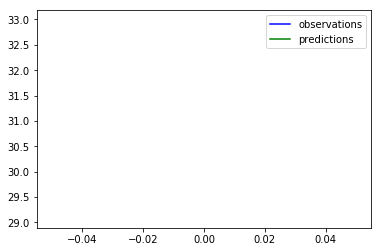

32.985270068469696

In [210]:
pred2 = arima_forecast(train, test, params=(1,1,0))[0][0]
pred2 

In [211]:
pred_lr = w_lr[0] * pred1 + w_lr[1] * pred2
print("linear regression: {}".format(pred_lr))

pred_ridge = w_ridge[0] * pred1 + w_ridge[1] * pred2
print("ridge regression: {}".format(pred_ridge))

print("true: {}".format(test[0]))

linear regression: 29.89499574041794
ridge regression: 29.893263057512875
true: 29.08641975308642


In [213]:
pred2

32.985270068469696

In [189]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=False)
A = np.array([pred1, pred2]).reshape((1,2))
regr.fit(A, test)
w_lr = regr.coef_

In [190]:
regr = linear_model.Ridge(fit_intercept=False, alpha=0.1)
A = np.array([pred1, pred2]).reshape((1,2))
regr.fit(A, test)
w_ridge = regr.coef_

In [191]:
pred_lr = w_lr[0] * pred1 + w_lr[1] * pred2
pred_lr

28.975609756097562

In [192]:
pred_ridge = w_ridge[0] * pred1 + w_ridge[1] * pred2
pred_ridge

28.973930359849298

In [21]:
"""
computation
"""
print("Computing...")
print()

print("*** SETUP ***")
for key, value in parameters.items():
    print("{}: {}".format(key, value))
print()
print("Experiment: {}".format(dir_name))
print() 

"""annual_predictions(targetNames, allPivotedTableDict, donor, pred_year, pred_interval, metrics_list, predMetrics,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name, num_top, stats) """

all_pred, all_true = annual_predictions(targetNames, allPivotedTableDict, donor, pred_interval, metrics_list, predMetrics,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name, top_players) 


Computing...

*** SETUP ***
starting_year: 1970
min_games: 30
pred_year: 2017
pred_interval: 1
min_num_years_played: 4

Experiment: plots/rsc/2017/sliding/no_normalization/1year/

Number of metrics: 9
Number of players: 206

*** MAPE ***
PTS_G    0.285086
AST_G    0.355552
TOV_G    0.343797
FG%      0.069197
FT%      0.069882
3P_G     0.988620
TRB_G    0.247745
STL_G    0.315481
BLK_G    0.439407
dtype: float64
MAPE for all:  0.33759855249078063


In [41]:
df = all_pred[all_pred.index=='PTS_G'] - all_true[all_true.index=='PTS_G']
df = df.T
df[~df.index.isin(nm)]

,PTS_G
Aaron Brooks 0,0.613760
Al Horford 0,-0.198670
Al Jefferson 0,3.731252
Al-Farouq Aminu 0,-1.191524
Alan Anderson 0,4.443022
Alec Burks 0,7.923300
Alexis Ajinca 0,1.443181
Amir Johnson 0,0.969062
Andre Drummond 0,3.130611
Andre Iguodala 0,-3.541171


In [ ]:
*** SETUP ***
starting_year: 1970
min_games: 30
pred_year: 2017
pred_interval: 1
min_num_years_played: 4

Experiment: plots/rsc/2017/sliding/variance/1year/

Number of metrics: 9
Number of players: 206

*** MAPE ***
PTS_G    0.289039
AST_G    0.364679
TOV_G    0.354601
FG%      0.069787
FT%      0.070612
3P_G     0.994520
TRB_G    0.252410
STL_G    0.372881
BLK_G    0.619039
dtype: float64
MAPE for all:  0.36792160362496357
​

In [ ]:
Computing...

*** SETUP ***
starting_year: 1970
min_games: 30
pred_year: 2017
pred_interval: 1
min_num_years_played: 4

Experiment: plots/rsc/2017/sliding/no_normalization/1year/

Number of metrics: 9
Number of players: 206

*** MAPE ***
PTS_G    0.285086
AST_G    0.355552
TOV_G    0.343797
FG%      0.069197
FT%      0.069882
3P_G     0.988620
TRB_G    0.247745
STL_G    0.315481
BLK_G    0.439407
dtype: float64
MAPE for all:  0.33759855249078063

In [ ]:
Computing...

*** SETUP ***
starting_year: 1970
min_games: 30
pred_year: 2016
pred_interval: 1
min_num_years_played: 4

Experiment: plots/rsc/sliding/variance/1year/

Number of metrics: 9
Number of players: 205

*** MAPE ***
PTS_G    0.292616
AST_G    0.396725
TOV_G    0.351284
FG%      0.070790
FT%      0.066157
3P_G     1.086676
TRB_G    0.258794
STL_G    0.362168
BLK_G    0.617673
dtype: float64
MAPE for all:  0.37528624313618186

In [ ]:
*** SETUP ***
starting_year: 1970
min_games: 30
pred_year: 2016
pred_interval: 1
min_num_years_played: 4

Experiment: plots/rsc/sliding/no_normalization/1year/

Number of metrics: 9
Number of players: 205

*** MAPE ***
PTS_G    0.292334
AST_G    0.378197
TOV_G    0.334752
FG%      0.070173
FT%      0.064969
3P_G     1.116008
TRB_G    0.264637
STL_G    0.319033
BLK_G    0.452872
dtype: float64
MAPE for all:  0.35119888395192483

In [54]:
print("Algo: outputs the mean of the player's history")
print("-----")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in targetNames:
    target = Target(playerName, allPivotedTableDict)
    true, pred = getBenchmark(target, predMetrics, pred_interval)
    
    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean()) 

Algo: outputs the mean of the player's history
-----
*** MAPE ***
PTS_G    0.517733
AST_G    0.461139
TOV_G    0.506419
FG%      0.068198
FT%      0.064929
3P_G     0.657768
TRB_G    0.350837
STL_G    0.378239
BLK_G    0.540355
dtype: float64
MAPE for all:  0.3903643711995076


In [56]:
pred_all['LeBron James']

PTS_G    27.335541
AST_G     6.913881
TOV_G     3.374093
FG%       0.498496
FT%       0.745208
3P_G      1.374531
TRB_G     7.144320
STL_G     1.705555
BLK_G     0.794567
Name: LeBron James, dtype: float64

In [57]:
true_all['LeBron James']

PTS_G    25.263158
AST_G     6.763158
TOV_G     3.276316
FG%       0.520480
FT%       0.731161
3P_G      1.144737
TRB_G     7.434211
STL_G     1.368421
BLK_G     0.644737
Name: LeBron James, dtype: float64

# DEBUGGING STAGE

In [42]:
playerName = 'Al Jefferson'
target = Target(playerName, allPivotedTableDict)
mrsc = mRSC(donor, target, pred_interval, probObservation=1)        
player_pred = pd.DataFrame()
player_true = pd.DataFrame()
        
"""# benchmark
true, benchmark = getBenchmark(target, predMetrics, pred_interval)
benchmark"""

'# benchmark\ntrue, benchmark = getBenchmark(target, predMetrics, pred_interval)\nbenchmark'

In [44]:
metric = metrics_list[0]

metric = predMetrics
mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [59]:
metric = metrics_list[0]

metric = predMetrics
mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)
pred = mrsc.predict()
pred = pred[pred.index.isin(predMetrics)]
true = mrsc.getTrue()
pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
player_pred = pd.concat([player_pred, pred], axis=0)
player_true = pd.concat([player_true, true], axis=0)

In [69]:
for i in range(mrsc.num_k):
    metric_plt = mrsc.metrics[i]
    print(pred[pred.index == metric_plt].values.flatten())

[14.385505363683219 12.911161072448229]
[1.702742145919105 1.5253697807658821]
[1.7192385770545187 1.564441901184189]
[0.48319136019142295 0.48629219665166257]
[0.7249183532344486 0.7164523271716283]
[0.3539001138955636 0.353363752435545]
[7.309900620690225 6.731121626472695]
[0.7971118479166359 0.7140108132435534]
[0.9611268100242883 0.8402310462167943]


In [61]:
pred_list = pred.values.flatten()
pred_list

array([14.385505363683219, 12.911161072448229, 1.702742145919105,
       1.5253697807658821, 1.7192385770545187, 1.564441901184189,
       0.48319136019142295, 0.48629219665166257, 0.7249183532344486,
       0.7164523271716283, 0.3539001138955636, 0.353363752435545,
       7.309900620690225, 6.731121626472695, 0.7971118479166359,
       0.7140108132435534, 0.9611268100242883, 0.8402310462167943],
      dtype=object)

In [53]:
i = 0
metric_plt = mrsc.metrics[i]
true_traj = mrsc.target.data[metric_plt].dropna(axis='columns').values.flatten()
true_traj.shape

(13,)

In [56]:
pred_traj = np.dot(mrsc.model.donor_pre.iloc[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].T, 
                                   mrsc.model.beta).flatten()
pred_traj = np.append(pred_traj, pred_list[i])

NameError: name 'pred_list' is not defined

In [ ]:
"""
targets
"""
activePlayers = getActivePlayers(stats, pred_year+pred_interval, buffer=buffer)
topPlayers = getTopPlayers(stats, pred_year, 'PTS', num_top_players).values.flatten().tolist()
#topPlayers = topPlayers.values.flatten().tolist()

print("non-rookie active players in 2016: ", len(activePlayers))

# first group
print("***** First Group *****")
target_names_1 = list(set(activePlayers) & set(topPlayers))
max_total_index = 20
print("* not sufficient donor pool:")
for playerName in target_names_1:
    target = Target(playerName, allPivotedTableDict)
    if (target.total_index > max_total_index):
        target_names_1.remove(playerName)
        print(playerName)
print("* total number of target players: ", len(target_names_1))

# second group
print()
print("***** Second Group *****")
target_names_2 = activePlayers
max_total_index = 20
print("* not sufficient donor pool:")
for playerName in target_names_2:
    target = Target(playerName, allPivotedTableDict)
    if (target.total_index > max_total_index):
        target_names_2.remove(playerName)
        print(playerName)
print("* total number of target players: ", len(target_names_2))
print()

##############
# final
targetNames = target_names_2
targetNames.sort()

if 'Kevin Garnett' in targetNames: 
    targetNames.remove("Kevin Garnett")
if 'Kobe Bryant' in targetNames:
    targetNames.remove("Kobe Bryant")

print("*** DONE! ***")

In [ ]:
metrics_to_use = allMetrics

print("Algo: outputs the mean of the player's history")
print("-----")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in targetNames:
    target = Target(playerName, allPivotedTableDict)
    true, pred = getBenchmark(target, metrics_to_use, pred_interval)
    
    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean()) 

In [295]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"fixed", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

metrics_list = [[x] for x in allMetrics]

"""
experiment
"""
print("1 metric at once")

all_pred = pd.DataFrame()
all_true = pd.DataFrame()
all_bench = pd.DataFrame()
all_R2 = pd.DataFrame()
for playerName in playerNames:
    target = Target(playerName, allPivotedTableDict)
    
    # benchmark
    true, benchmark = getBenchmark(target, ["PTS_G"], pred_interval)
    
    # prediction
    mrsc = mRSC(donor, target, pred_interval, probObservation=1)
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
        pred = mrsc.predict()
        true = mrsc.getTrue()
        pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        player_pred = pd.concat([player_pred, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
    all_pred = pd.concat([all_pred, player_pred], axis=1)
    all_true = pd.concat([all_true, player_true], axis=1)
    all_bench = pd.concat([all_bench, benchmark], axis=1)
    
    R2 = getR2(player_true, player_pred, benchmark)
    all_R2 = pd.concat([all_R2, R2], axis=1)

##################
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())

print()
print("*** R2 ***")
print(all_R2.mean(axis=1))
print("R2 for all: ", all_R2.mean(axis=1).mean(axis=0))

edited_R2 = copy.deepcopy(all_R2)
edited_R2[edited_R2 <0] = 0
print()
print("*** edited R2 ***")
print(edited_R2.mean(axis=1))
print("R2 for all: ", edited_R2.mean().mean())
##############################################################

1 metric at once
(10, 134)
*** MAPE ***
PTS_G    0.277280
AST_G    0.303132
TOV_G    0.281037
TRB_G    0.232480
STL_G    0.268172
BLK_G    0.371174
3P_G     0.897202
FG%      0.060781
FT%      0.061157
PER_w    0.174422
dtype: float64
MAPE for all:  0.2810383781032388

*** RMSE ***
PTS_G    3.078215
AST_G    0.939275
TOV_G    0.421465
TRB_G    1.394864
STL_G    0.235441
BLK_G    0.195664
3P_G     0.874437
FG%      0.035825
FT%      0.058761
PER_w    2.891542
dtype: float64
RMSE for all:  1.012548902251213

*** R2 ***
PTS_G   -68.137314
AST_G     0.989566
TOV_G     0.997875
TRB_G    -4.560719
STL_G     0.999339
BLK_G     0.999462
3P_G      0.990676
FG%       0.999979
FT%       0.999935
PER_w   -14.244623
dtype: float64
R2 for all:  -7.996582330214866

*** edited R2 ***
PTS_G    0.423362
AST_G    0.989566
TOV_G    0.997875
TRB_G    0.856446
STL_G    0.999339
BLK_G    0.999462
3P_G     0.990676
FG%      0.999979
FT%      0.999935
PER_w    0.603814
dtype: float64
R2 for all:  0.88604549089

In [294]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

metrics_list = [[x] for x in allMetrics]

"""
experiment
"""
print("1 metric at once")

all_pred = pd.DataFrame()
all_true = pd.DataFrame()
all_bench = pd.DataFrame()
all_R2 = pd.DataFrame()
for playerName in playerNames:
    target = Target(playerName, allPivotedTableDict)
    
    # benchmark
    true, benchmark = getBenchmark(target, ["PTS_G"], pred_interval)
    
    # prediction
    mrsc = mRSC(donor, target, pred_interval, probObservation=1)
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
        pred = mrsc.predict()
        true = mrsc.getTrue()
        pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        player_pred = pd.concat([player_pred, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
    all_pred = pd.concat([all_pred, player_pred], axis=1)
    all_true = pd.concat([all_true, player_true], axis=1)
    all_bench = pd.concat([all_bench, benchmark], axis=1)
    
    R2 = getR2(player_true, player_pred, benchmark)
    all_R2 = pd.concat([all_R2, R2], axis=1)

##################
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())

print()
print("*** R2 ***")
print(all_R2.mean(axis=1))
print("R2 for all: ", all_R2.mean(axis=1).mean(axis=0))

edited_R2 = copy.deepcopy(all_R2)
edited_R2[edited_R2 <0] = 0
print()
print("*** edited R2 ***")
print(edited_R2.mean(axis=1))
print("R2 for all: ", edited_R2.mean().mean())
##############################################################

1 metric at once
(10, 134)
*** MAPE ***
PTS_G    0.285066
AST_G    0.296102
TOV_G    0.277888
TRB_G    0.221688
STL_G    0.271170
BLK_G    0.378055
3P_G     0.620813
FG%      0.062568
FT%      0.061464
PER_w    0.176787
dtype: float64
MAPE for all:  0.2583693415639397

*** RMSE ***
PTS_G    3.125182
AST_G    0.935674
TOV_G    0.420983
TRB_G    1.367314
STL_G    0.240406
BLK_G    0.204238
3P_G     0.490811
FG%      0.037340
FT%      0.058443
PER_w    3.152154
dtype: float64
RMSE for all:  1.003254594593438

*** R2 ***
PTS_G   -88.662326
AST_G     0.988888
TOV_G     0.997892
TRB_G    -1.950227
STL_G     0.999319
BLK_G     0.999350
3P_G      0.997055
FG%       0.999977
FT%       0.999936
PER_w   -10.868037
dtype: float64
R2 for all:  -9.449817350209434

*** edited R2 ***
PTS_G    0.411329
AST_G    0.988888
TOV_G    0.997892
TRB_G    0.836763
STL_G    0.999319
BLK_G    0.999350
3P_G     0.997055
FG%      0.999977
FT%      0.999936
PER_w    0.569363
dtype: float64
R2 for all:  0.87998723292

# Grouping

In [269]:
# check if grouping with n=2 would work
"""
experiment setup
"""
# overall setup
donorSetup= [None,"Sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

"""
experiment
"""
result = pd.DataFrame(index=allMetrics, columns=allMetrics)
for m1 in range(len(allMetrics)):
    for m2 in range(len(allMetrics)):
        metric1 = allMetrics[m1]
        metric2 = allMetrics[m2]
        metrics = [metric1, metric2]
        metrics_list = [metrics]
        print()
        print("***************************************")
        print(metrics)

        all_pred = pd.DataFrame()
        all_true = pd.DataFrame()
        all_bench = pd.DataFrame()
        all_R2 = pd.DataFrame()
        for playerName in playerNames:
            target = Target(playerName, allPivotedTableDict)

            # benchmark
            true, benchmark = getBenchmark(target, metrics, pred_interval)

            # prediction
            mrsc = mRSC(donor, target, pred_interval, probObservation=1)
            player_pred = pd.DataFrame()
            player_true = pd.DataFrame()
            for i in range(len(metrics_list)):
                mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
                pred = mrsc.predict()
                true = mrsc.getTrue()
                pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
                true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
                player_pred = pd.concat([player_pred, pred], axis=0)
                player_true = pd.concat([player_true, true], axis=0)
            all_pred = pd.concat([all_pred, player_pred], axis=1)
            all_true = pd.concat([all_true, player_true], axis=1)
            all_bench = pd.concat([all_bench, benchmark], axis=1)

            R2 = getR2(player_true, player_pred, benchmark)
            all_R2 = pd.concat([all_R2, R2], axis=1)

        ##################
#         print(all_pred.shape)
        mask = (all_true !=0 )
        mape = np.abs(all_pred - all_true) / all_true[mask]
        print("*** MAPE ***")
        print(mape.mean(axis=1))
        result.iloc[m1,m2] = mape.mean(axis=1).values[0]
print(result)
diff = (result.T - mape.mean(axis=1).values).T


***************************************
['PTS_G', 'PTS_G']
*** MAPE ***
PTS_G    0.285066
PTS_G    0.285066
dtype: float64

***************************************
['PTS_G', 'AST_G']
*** MAPE ***
PTS_G    0.283337
AST_G    0.409922
dtype: float64

***************************************
['PTS_G', 'TOV_G']
*** MAPE ***
PTS_G    0.285706
TOV_G    0.393103
dtype: float64

***************************************
['PTS_G', 'TRB_G']
*** MAPE ***
PTS_G    0.300432
TRB_G    0.244106
dtype: float64

***************************************
['PTS_G', 'STL_G']
*** MAPE ***
PTS_G    0.284957
STL_G    0.421654
dtype: float64

***************************************
['PTS_G', 'BLK_G']
*** MAPE ***
PTS_G    0.285237
BLK_G    1.371677
dtype: float64

***************************************
['PTS_G', '3P_G']
*** MAPE ***
PTS_G    0.285382
3P_G     2.160642
dtype: float64

***************************************
['PTS_G', 'FG%']
*** MAPE ***
PTS_G    0.285094
FG%      0.337157
dtype: float64

**********

*** MAPE ***
3P_G    0.620813
3P_G    0.620813
dtype: float64

***************************************
['3P_G', 'FG%']
*** MAPE ***
3P_G    0.609159
FG%     0.063301
dtype: float64

***************************************
['3P_G', 'FT%']
*** MAPE ***
3P_G    0.519625
FT%     0.061411
dtype: float64

***************************************
['3P_G', 'PER_w']
*** MAPE ***
3P_G     2.444566
PER_w    0.177107
dtype: float64

***************************************
['FG%', 'PTS_G']
*** MAPE ***
FG%      0.337157
PTS_G    0.285094
dtype: float64

***************************************
['FG%', 'AST_G']
*** MAPE ***
FG%      0.540236
AST_G    0.300862
dtype: float64

***************************************
['FG%', 'TOV_G']
*** MAPE ***
FG%      0.347302
TOV_G    0.280622
dtype: float64

***************************************
['FG%', 'TRB_G']
*** MAPE ***
FG%      0.362217
TRB_G    0.230544
dtype: float64

***************************************
['FG%', 'STL_G']
*** MAPE ***
FG%      0.062644


In [290]:
diff = (result.T - mape.mean(axis=1).values).T
diff[diff<0].astype(float).round(3)

,PTS_G,AST_G,TOV_G,TRB_G,STL_G,BLK_G,3P_G,FG%,FT%,PER_w
PTS_G,NaN,-0.002,NaN,NaN,-0.000,NaN,NaN,NaN,NaN,NaN
AST_G,NaN,NaN,NaN,NaN,NaN,NaN,-0.003,NaN,-0.005,NaN
TOV_G,NaN,-0.017,NaN,NaN,NaN,NaN,-0.018,NaN,-0.012,NaN
TRB_G,NaN,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,NaN,NaN
STL_G,NaN,-0.003,NaN,NaN,-0.000,-0.009,NaN,NaN,-0.001,NaN
BLK_G,NaN,NaN,NaN,NaN,-0.006,NaN,NaN,-0.003,-0.004,NaN
3P_G,NaN,NaN,NaN,NaN,NaN,-0.018,-0.000,-0.012,-0.101,NaN
FG%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FT%,NaN,NaN,NaN,NaN,NaN,-0.001,-0.000,NaN,NaN,NaN
PER_w,NaN,NaN,NaN,NaN,NaN,-0.000,NaN,-0.000,NaN,NaN


# Weighting

In [ ]:
# metrics_list = [['PTS_G'],
#  ['AST_G'],
#  ['TOV_G'],
#  ['TRB_G'],
#  ['STL_G'],
#  ['BLK_G'],
#  ['3P_G'],
#  ['FG%'],
#  ['FT%','3P_G'],
#  ['PER_w']]

metrics_list = [[x] for x in allMetrics]

In [324]:
"""
experiment setup
"""
print("variance")
# overall setup
donorSetup= ["variance","sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

"""
experiment
"""
all_pred = pd.DataFrame()
all_true = pd.DataFrame()
all_bench = pd.DataFrame()
all_R2 = pd.DataFrame()
for playerName in playerNames:
    target = Target(playerName, allPivotedTableDict)
    
    # benchmark
    true, benchmark = getBenchmark(target, ["PTS_G"], pred_interval)
    
    # prediction
    mrsc = mRSC(donor, target, pred_interval, probObservation=1)
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
        pred = mrsc.predict()
        true = mrsc.getTrue()
        pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        player_pred = pd.concat([player_pred, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
    all_pred = pd.concat([all_pred, player_pred], axis=1)
    all_true = pd.concat([all_true, player_true], axis=1)
    all_bench = pd.concat([all_bench, benchmark], axis=1)
    
    R2 = getR2(player_true, player_pred, benchmark)
    all_R2 = pd.concat([all_R2, R2], axis=1)

##################
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())

print()
print("*** R2 ***")
print(all_R2.mean(axis=1))
print("R2 for all: ", all_R2.mean(axis=1).mean(axis=0))

edited_R2 = copy.deepcopy(all_R2)
edited_R2[edited_R2 <0] = 0
print()
print("*** edited R2 ***")
print(edited_R2.mean(axis=1))
print("R2 for all: ", edited_R2.mean().mean())
##############################################################

variance
(10, 134)
*** MAPE ***
PTS_G    0.283308
AST_G    0.293132
TOV_G    0.276494
TRB_G    0.218923
STL_G    0.272439
BLK_G    0.425095
3P_G     0.558330
FG%      0.062566
FT%      0.062136
PER_w    0.178784
dtype: float64
MAPE for all:  0.2574142131362448

*** RMSE ***
PTS_G    3.108842
AST_G    0.935796
TOV_G    0.418640
TRB_G    1.336256
STL_G    0.234032
BLK_G    0.193097
3P_G     0.452773
FG%      0.037343
FT%      0.059003
PER_w    3.196666
dtype: float64
RMSE for all:  0.9972447301011511

*** R2 ***
PTS_G   -88.041827
AST_G     0.988982
TOV_G     0.997898
TRB_G    -1.653613
STL_G     0.999367
BLK_G     0.999376
3P_G      0.997531
FG%       0.999976
FT%       0.999935
PER_w   -11.083148
dtype: float64
R2 for all:  -9.37955221414564

*** edited R2 ***
PTS_G    0.412167
AST_G    0.988982
TOV_G    0.997898
TRB_G    0.840461
STL_G    0.999367
BLK_G    0.999376
3P_G     0.997531
FG%      0.999976
FT%      0.999935
PER_w    0.563459
dtype: float64
R2 for all:  0.8799152469536123


In [325]:
"""
experiment setup
"""
print("normalize")
# overall setup
donorSetup= ["normalize","sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

"""
experiment
"""
all_pred = pd.DataFrame()
all_true = pd.DataFrame()
all_bench = pd.DataFrame()
all_R2 = pd.DataFrame()
for playerName in playerNames:
    target = Target(playerName, allPivotedTableDict)
    
    # benchmark
    true, benchmark = getBenchmark(target, ["PTS_G"], pred_interval)
    
    # prediction
    mrsc = mRSC(donor, target, pred_interval, probObservation=1)
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
        pred = mrsc.predict()
        true = mrsc.getTrue()
        pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        player_pred = pd.concat([player_pred, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
    all_pred = pd.concat([all_pred, player_pred], axis=1)
    all_true = pd.concat([all_true, player_true], axis=1)
    all_bench = pd.concat([all_bench, benchmark], axis=1)
    
    R2 = getR2(player_true, player_pred, benchmark)
    all_R2 = pd.concat([all_R2, R2], axis=1)

##################
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())

print()
print("*** R2 ***")
print(all_R2.mean(axis=1))
print("R2 for all: ", all_R2.mean(axis=1).mean(axis=0))

edited_R2 = copy.deepcopy(all_R2)
edited_R2[edited_R2 <0] = 0
print()
print("*** edited R2 ***")
print(edited_R2.mean(axis=1))
print("R2 for all: ", edited_R2.mean().mean())
##############################################################

normalize
(10, 134)
*** MAPE ***
PTS_G     0.473115
AST_G     0.382205
TOV_G     0.398554
TRB_G     0.326884
STL_G     0.747976
BLK_G     0.641573
3P_G      1.034586
FG%       0.199636
FT%      11.435996
PER_w     0.539404
dtype: float64
MAPE for all:  1.6179340352100255

*** RMSE ***
PTS_G     4.930995
AST_G     1.202499
TOV_G     0.591635
TRB_G     1.817813
STL_G     0.637192
BLK_G     0.351938
3P_G      0.742832
FG%       0.133928
FT%      24.627570
PER_w    10.199659
dtype: float64
RMSE for all:  4.523606149794006

*** R2 ***
PTS_G   -229.886493
AST_G      0.977291
TOV_G      0.995292
TRB_G    -15.726024
STL_G      0.994958
BLK_G      0.997905
3P_G       0.992850
FG%        0.999770
FT%       -6.410267
PER_w    -97.628441
dtype: float64
R2 for all:  -34.36931588960094

*** edited R2 ***
PTS_G    0.302402
AST_G    0.977291
TOV_G    0.995292
TRB_G    0.834267
STL_G    0.994958
BLK_G    0.997905
3P_G     0.992850
FG%      0.999770
FT%      0.804334
PER_w    0.282870
dtype: float64
R2 